In [28]:
import numpy as np 
import pandas as pd 
import cv2
import os # used
from xml.etree import ElementTree # import to read/locate xml elemnts 
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
keras = tf.keras


In [39]:
classes = ['person','person-like'] # text to locate inside the xml person or person like
labeled_class = {class_name:i for i, class_name in enumerate(classes)} # setting up the dict keys person/personlike
# iteriate, save the class labels 'person,person like'

n_classes = 2 
# 2 classes person or person like

size = (500,442) 
#image org size 500 x 442

In [40]:
# create a function to load in data and label the classes person or person like

def load_data():
     # datasets variable list of the 3 folders for train,test and validation
    datasets = ['Train/Train', 'Test/Test', 'Val/Val'] 
    output = []
    
    for dataset in datasets:
        
        images = [] # create list
        labels = [] # create list 
        
        # adding the dataset loop to the file path of Annotations(xml files)
        directoryANNOTATE = "Data/Pdata/" + dataset + "/Annotations/" 
        
        # adding the dataset loop to file path of images 
        directoryIMGAGES = "Data/Pdata/" + dataset + "/JPEGImages/" 
        
        # listdir() returns a list containing the names of the entries in the directory given by path, now we can loop it
        file = os.listdir(directoryANNOTATE) 
        jpg = os.listdir(directoryIMGAGES) 
        
        # organizing the annotations files to match the image order so the classes are labeled corrrctly to each image
        file.sort() 
        
        # organizing the images to match the order of the xml so the images are labeled correctly(person,like person)
        jpg.sort() 
        
        
        i = 0
        
        # loop through the xml files(file_) 
        #we need to match and idenify the class of each image by matching it with the annotation xml file
        for xml in file:
            
            # combining the annotations with the xml 
            xmlf = os.path.join(directoryANNOTATE,xml)
            
            # ElementTree represents the whole XML folder as a tree, and Element represents a single node in this tree. 
            dom = ElementTree.parse(xmlf)
            
            # iteriate through the xml annotations files and locate object element
            objct = dom.findall('object')  
            
            # from the object element now locate name element in the xml annotation file and only take the first object
            label_name = objct[0].find('name').text 
            
            # this will append all text either 'person / person like' found in the xml file
            # inside the name element, and saved off to the labeled_class 
            labels.append(labeled_class[label_name]) 
          
            # directory for images and the list of images to loop through
            img_path = directoryIMGAGES + jpg[i] 
            
            # taking rbg color value and assigning to tensor(3 dim matrix) imagedataimagegen
            curr_img = cv2.imread(img_path)
            
            # resize the org image to my custom perference 
            curr_img = cv2.resize(curr_img, size)
            
            #append the list of images that have been resized 
            images.append(curr_img) 
            # +1 to move to a diff image every loop
            i +=1
            
        # creating a numpy array of tensors, instead of list of tensors
        images = np.array(images, dtype='float32')
        
        # normalizing all images so the pixel values are between 0-1(imagedatagen)
        images = images / 255
        
        
        # tranforming the list of tensor to a numpy array.
        labels = np.array(labels, dtype='int32')
        
        
        # creating the list and joining together the labels and images
        output.append((images, labels)) 
    return output

In [41]:
# loading in the data
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [42]:
# confirm train size
train_images.shape

(944, 442, 500, 3)

In [43]:
# confirm label size matches image size (train_label = annotation xml files with class indication person or person_like)
train_labels.shape

(944,)

In [44]:
val_images.shape

(160, 442, 500, 3)

In [45]:
test_images.shape

(235, 442, 500, 3)

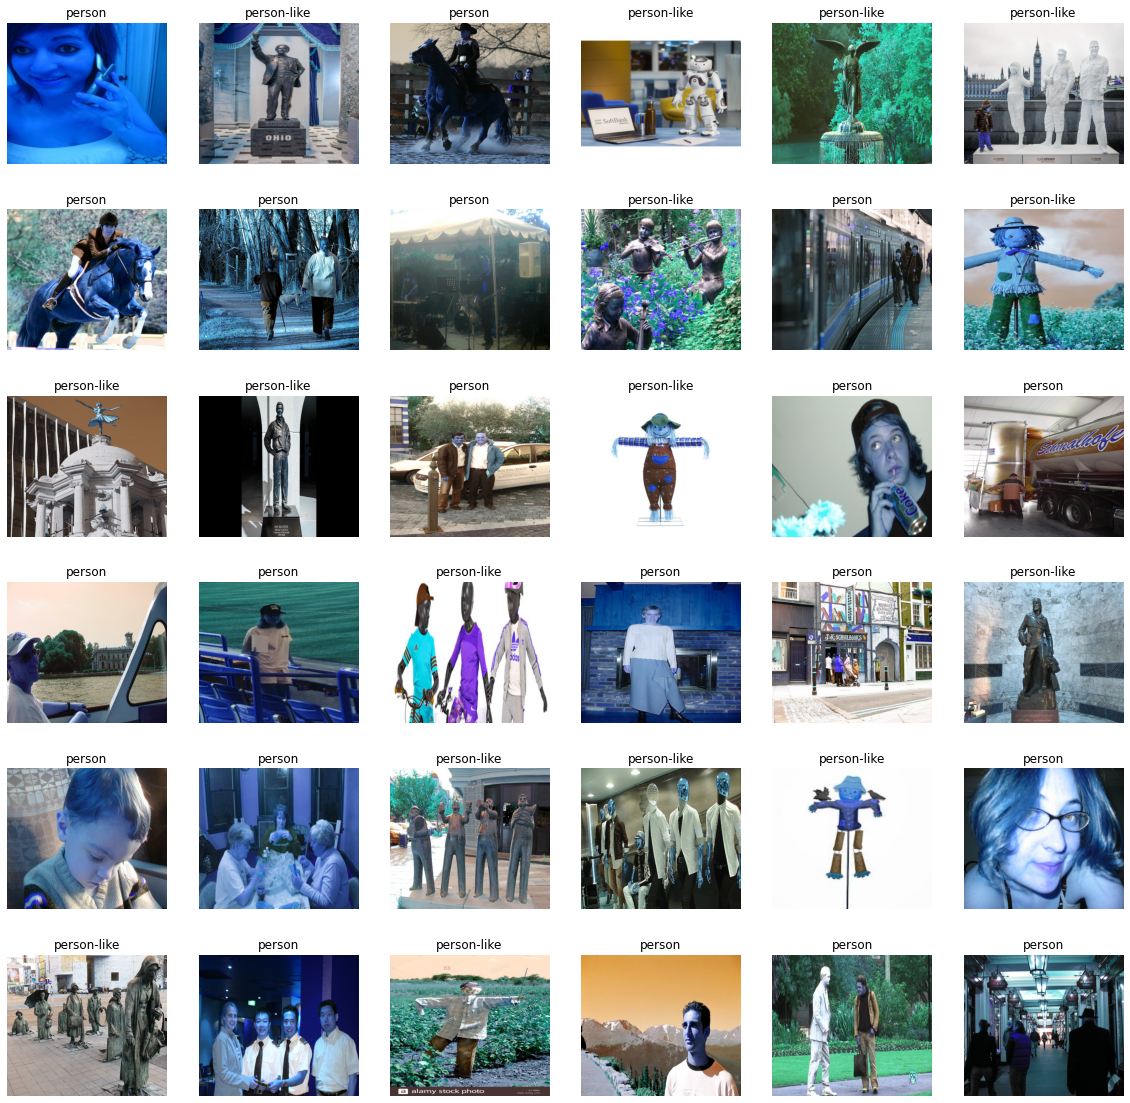

In [46]:
# looking at rabdom images from training data
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])  
    plt.title(classes[train_labels[i]])
    plt.axis('off')

In [47]:
#Conv2d hyperparameter layout ( filter= learns how to detect a person or personlike when trained on the following images
#                Kernel= the size of the matrix as it reviews the image 
#                strides= how many vectors the kernel moves across the matrix 
#                padding=analyzes the image to the edge/corner and beyond by 1 vector to optimize the analysis
#                activation = the type of regulation system to help prevent overfitting
#                input= pixel shape of image(200,200 matrix) and last digit in this case 3 = rgb(color image scale)
#                3 values combined in a single pixel will represent the final color the pixel displays
#                red value = 0, blue= 255, green= 255 this combination will result in yellow
#                255 is the brightest and highest value, will 1 being most faint, zero results as nonpresent  )

# Flatten

# RMSProp with momentum generates its parameter updates using a momentum on the rescaled gradient,
# binary model only two classes
# specifically optimizing tp & fp want to detect all images correctly 


In [38]:
# create CNN model 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(500, 442, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
30/30 [==============================] - 9s 292ms/step - loss: 0.7559 - accuracy: 0.5667 - val_loss: 0.7138 - val_accuracy: 0.4688
Epoch 2/10
30/30 [==============================] - 9s 308ms/step - loss: 0.6861 - accuracy: 0.5456 - val_loss: 0.6223 - val_accuracy: 0.6625
Epoch 3/10
30/30 [==============================] - 9s 293ms/step - loss: 0.6964 - accuracy: 0.6144 - val_loss: 0.7538 - val_accuracy: 0.5312
Epoch 4/10
30/30 [==============================] - 9s 292ms/step - loss: 0.6481 - accuracy: 0.6282 - val_loss: 0.5730 - val_accuracy: 0.6938
Epoch 5/10
30/30 [==============================] - 10s 318ms/step - loss: 0.6618 - accuracy: 0.6356 - val_loss: 0.5980 - val_accuracy: 0.6875
Epoch 6/10
30/30 [==============================] - 9s 298ms/step - loss: 0.6117 - accuracy: 0.6706 - val_loss: 0.5859 - val_accuracy: 0.6313
Epoch 7/10
30/30 [==============================] - 9s 300ms/step - loss: 0.5725 - accuracy: 0.7235 - val_loss: 0.7090 - val_accuracy: 0.5500
Epoch

In [48]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


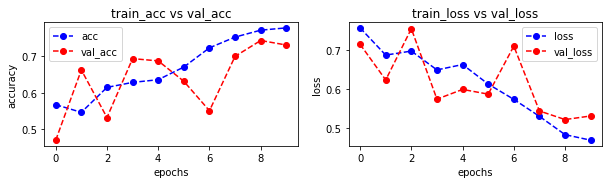

In [49]:
plot_accuracy_loss(history)

In [50]:
preds = model.predict(val_images) 

ValueError: in user code:

    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Public\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_6 is incompatible with the layer: expected axis -1 of input shape to have value 2700 but received input with shape [32, 291060]


In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])    
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites. 
    plt.title((classes[x]))

In [ ]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [ ]:
tp, fp, tn, fn = confusion_matrix(val_labels,result).ravel()

In [ ]:
(tp, tn, fp, fp)

#There are a few important differences between RMSProp with momentum and Adam: RMSProp with momentum generates its 
    parameter updates using a momentum on the rescaled gradient, whereas Adam updates are directly estimated using 
    a running average of first and second moment of the gradient
    
    
    tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam',
    **kwargs
    
    tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=100,
    jit_compile=True,
    name="RMSprop",
    **kwargs